In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms, datasets
# 모델 요약
from torchvision import models, utils
from torchsummary import summary

In [2]:
## 네트워크를 저장하거나 불러오는 함수 작성하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               '%s/model_epoch%d.pth' % (ckpt_dir, epoch))

def load(ckpt_dir, net, optim):
    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort()

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])

    return net, optim

In [3]:
# 학습률, batch, epoch
lr = 1e-3
batch_size = 64
num_epoch = 10

# 학습된 network가 저장될 디렉터리
ckpt_dir = 'D:/torchtorch/checkpoint9'
# 텐서보드 파일이 저장될 디렉터리
log_dir = 'D:/torchtorch/log9'
# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# 기존 ImageNet 학습한 resnet18 모델 불러오기 
Model_RESNET18 = models.resnet18(pretrained=True)
# # ImageNet을 사전 학습한 weight를 그대로 사용하기 위한 code
# for param in Model_RESNET18.parameters():
#     param.requires_grad = False    

# 기존 학습된 features 불러오기
Num_Features = Model_RESNET18.fc.in_features
# 10개의 클래스만 분류하면 되므로 마지막 fc layer만 변경해주기
Model_RESNET18.fc = nn.Linear(Num_Features, 10).cuda()
# GPU 할당
Model_RESNET18 = Model_RESNET18.to(device)

In [5]:
## 모델 요약
print(summary(Model_RESNET18, (3,244,244)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]          36,864
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
       BasicBlock-11           [-1, 64, 61, 61]               0
           Conv2d-12           [-1, 64, 61, 61]          36,864
      BatchNorm2d-13           [-1, 64, 61, 61]             128
             ReLU-14           [-1, 64,

In [6]:
from torch.optim import lr_scheduler
## 필요한 손실함수 구현하기

fn_loss = nn.CrossEntropyLoss().to(device)
fn_pred = lambda output: torch.softmax(output, dim=1)
fn_acc = lambda pred, label: ((pred.max(dim=1)[1] == label).type(torch.float)).mean()

optim = torch.optim.Adam(Model_RESNET18.parameters(), lr=lr)

# train과 다른점 - load
net, optim = load(ckpt_dir=ckpt_dir, net=Model_RESNET18, optim=optim)

In [7]:
## CIFAR10 데이터 불러오기
## 이미지 전처리 과정
# 1. 이미지 텐서 변환 및 정규화 등 수행(.Compose) 
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,)),
                                # 이미지 resize, resize하면서 생기는 pixel은 BILINEAR interpolation 수행
                                transforms.Resize(224, interpolation=2)])

# 2. 데이터셋 불러오기
dataset = datasets.CIFAR10(download=True, root='./.data/', train=False, transform=transform)

# 3. 데이터셋 나누기
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# 4. 1배치에 들어갈 데이터 
# 1epoch = 10000개 = 64batch
# 1batch = 10000/64(batch_size) = 157
num_data = len(loader.dataset)
num_batch = np.ceil(num_data / batch_size)

Files already downloaded and verified


In [8]:
print(num_data)
print(num_batch)

10000
157.0


In [9]:
## evaluation 시작하기
predictions_list = []
labels_list = []

with torch.no_grad():
    Model_RESNET18.eval()

    loss_arr = []
    acc_arr = []

    # 다른점 - backpropagation 과정 제거
    for batch, (input, label) in enumerate(loader, 1):
        
        labels_list.append(label)
        input = input.to(device)
        label = label.to(device)

        output = Model_RESNET18(input)
        
        pred = fn_pred(output)
        loss = fn_loss(output, label)
        acc = fn_acc(pred, label)

        predictions_list.append(torch.max(output,1)[1])
        loss_arr += [loss.item()]
        acc_arr += [acc.item()]

        print('TEST: BATCH %04d/%04d | LOSS: %.4f | ACC %.4f' %
              (batch, num_batch, np.mean(loss_arr), np.mean(acc_arr)))

TEST: BATCH 0001/0157 | LOSS: 0.5312 | ACC 0.8594
TEST: BATCH 0002/0157 | LOSS: 0.4042 | ACC 0.8672
TEST: BATCH 0003/0157 | LOSS: 0.4322 | ACC 0.8281
TEST: BATCH 0004/0157 | LOSS: 0.4342 | ACC 0.8359
TEST: BATCH 0005/0157 | LOSS: 0.4256 | ACC 0.8406
TEST: BATCH 0006/0157 | LOSS: 0.4240 | ACC 0.8516
TEST: BATCH 0007/0157 | LOSS: 0.4165 | ACC 0.8549
TEST: BATCH 0008/0157 | LOSS: 0.4106 | ACC 0.8535
TEST: BATCH 0009/0157 | LOSS: 0.3999 | ACC 0.8594
TEST: BATCH 0010/0157 | LOSS: 0.3755 | ACC 0.8703
TEST: BATCH 0011/0157 | LOSS: 0.3684 | ACC 0.8736
TEST: BATCH 0012/0157 | LOSS: 0.3760 | ACC 0.8724
TEST: BATCH 0013/0157 | LOSS: 0.3865 | ACC 0.8666
TEST: BATCH 0014/0157 | LOSS: 0.4072 | ACC 0.8627
TEST: BATCH 0015/0157 | LOSS: 0.4009 | ACC 0.8656
TEST: BATCH 0016/0157 | LOSS: 0.3942 | ACC 0.8682
TEST: BATCH 0017/0157 | LOSS: 0.3930 | ACC 0.8667
TEST: BATCH 0018/0157 | LOSS: 0.3890 | ACC 0.8681
TEST: BATCH 0019/0157 | LOSS: 0.3816 | ACC 0.8692
TEST: BATCH 0020/0157 | LOSS: 0.3839 | ACC 0.8672


In [10]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

# print(predictions_l)
# print(labels_l)

In [11]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1000
           1       0.95      0.95      0.95      1000
           2       0.81      0.83      0.82      1000
           3       0.72      0.79      0.75      1000
           4       0.87      0.84      0.85      1000
           5       0.80      0.83      0.82      1000
           6       0.83      0.93      0.88      1000
           7       0.95      0.84      0.89      1000
           8       0.92      0.91      0.92      1000
           9       0.93      0.89      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000




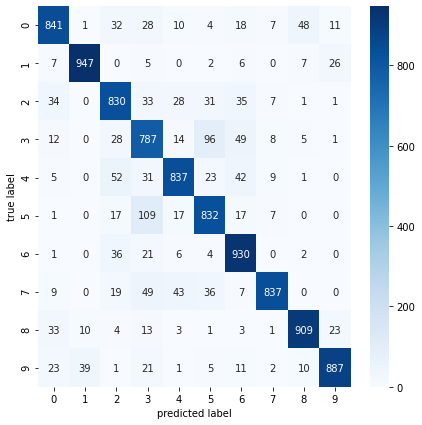

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 혼동 행렬을 만듭니다.
plt.figure(figsize = (7, 7))
cm = confusion_matrix(labels_l, predictions_l)
sns.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()